a bit DIY here
- for each star of interest
- pull LCs from lightkurve
- for each short-cadence LC, do some simple iterative detrending & flare finding
- mind the gaps
- combine the close events
- tune this for the data in hand, not in general
- save flare catalog/table for every star

hopefully can steal chunks of this code from the HelloTESS stuff?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.table import Table

from stuff import *
import exoplanet as xo

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
FS = pd.read_csv('flare_sample_step1.csv')
FS

,KIC,TIC,Nfl,K1min,K30min,T2min
0,11143395,27236187,2,0.0,1.0,2.0
1,11495571,48504458,2,0.0,15.0,1.0
2,6117602,122136861,2,0.0,17.0,3.0
3,8408875,123229811,2,0.0,4.0,2.0
4,8682921,159047957,2,1.0,18.0,2.0
5,8429280,159721038,3,1.0,18.0,3.0
6,9153754,159761686,3,0.0,4.0,2.0
7,9201463,164458193,3,0.0,17.0,4.0
8,7505473,164463430,3,0.0,4.0,4.0
9,7341653,164644375,11,0.0,16.0,4.0


In [4]:
# let's start with k=5 (KIC 8429280), since it has 1min, 30min, and 2min

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

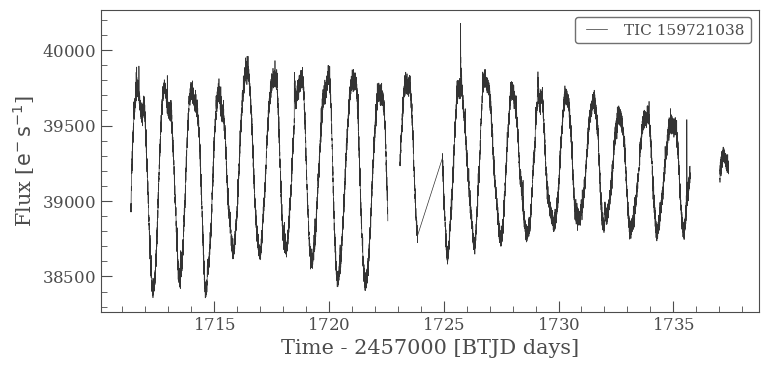

In [5]:
k=5
lc = lk.search_lightcurve('TIC'+str(FS['TIC'].values[k]), mission='TESS', exptime=120)[0].download()
lc.plot()

In [6]:
# Nshort = np.zeros(sum(m1))
# Nlong = np.zeros(sum(m1))
# Ntess = np.zeros(sum(m1))
# for k in range(sum(m1)):
#     Nshort[k] = len(lk.search_lightcurve(str(spK['KIC'][m1].values[k]), mission='Kepler', exptime=60))
#     Nlong[k] = len(lk.search_lightcurve(str(spK['KIC'][m1].values[k]), mission='Kepler', exptime=1800))
#     Ntess[k] = len(lk.search_lightcurve(str(spK['KIC'][m1].values[k]), mission='TESS', exptime=120))

In [63]:
# make harsh quality cuts, and chop out a known bad window of time (might add more later)
AOK = (lc['quality'].data == 0) & ((lc['time'].value < 1347) | (lc['time'].value > 1350))
med = np.nanmedian(lc['pdcsap_flux'].value[AOK])
xtr = 5

# ACF w/ Exoplanet package
acf = xo.autocorr_estimator(lc['time'].value[AOK], lc['pdcsap_flux'].value[AOK] / med,
                            yerr=lc['pdcsap_flux_err'].value[AOK] / med,
                            min_period=0.07, max_period=27, max_peaks=2)
if len(acf['peaks']) > 0:
    ACF_1dt = acf['peaks'][0]['period']
    ACF_1pk = acf['autocorr'][1][np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]][0]

    scl = np.abs(np.nanmedian(np.diff(lc['time'].value)))
    s_window = int(ACF_1dt / scl / xtr)
else:
    s_window = 128

# window must be odd for some smooth approaches
if (s_window % 2) == 0:
    s_window -= 1
    
print(scl, s_window, ACF_1dt)

0.0013888666305774677 167 1.1603881490073036


In [64]:
yerr = lc['pdcsap_flux_err'].value[AOK] / med
x = lc['time'].value[AOK]
y = (lc['pdcsap_flux'].value[AOK] - med)/med


(1731.0, 1735.0)

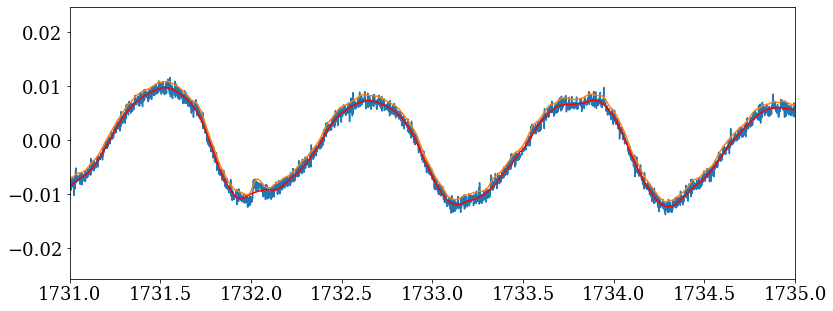

In [65]:
# https://stackoverflow.com/a/20642478
from scipy.signal import savgol_filter

yhat = savgol_filter(y, s_window, 3) # window size 51, polynomial order 3

plt.figure(figsize=(13,5))

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.plot(x, map_soln["pred"], label="model")
plt.xlim(1731,1735)
# plt.plot(x, y - yhat)

In [8]:
import pymc3 as pm
import theano.tensor as tt


In [32]:
%time
# from tutorial: https://docs.exoplanet.codes/en/v0.1.1/tutorials/stellar-variability/

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(ACF_1dt), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = pm.find_MAP(start=model.test_point)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


logp = 93,878, ||grad|| = 3.3879: 100%|███████| 123/123 [00:01<00:00, 77.76it/s]


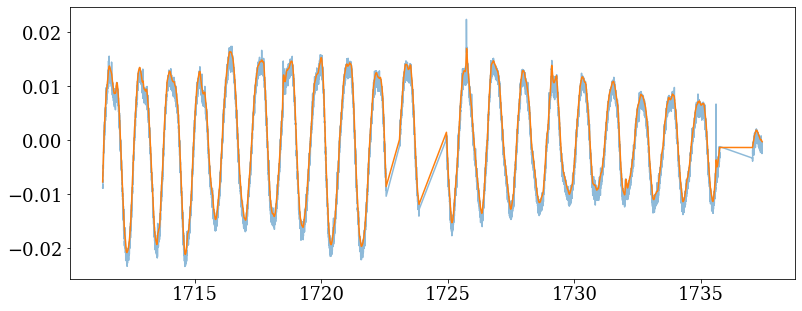

In [33]:
plt.figure(figsize=(13,5))
plt.plot(x, y,label="data", alpha=0.5)
plt.plot(x, map_soln["pred"], label="model")
# plt.xlim(x.min(), x.max())
# plt.xlim(x.min()+5, x.min()+7)

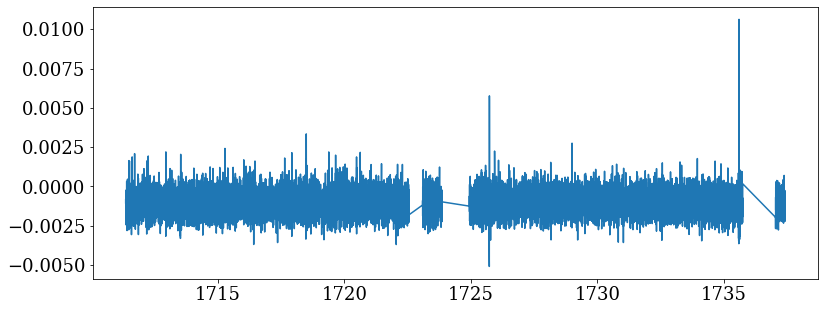

In [34]:
plt.figure(figsize=(13,5))
plt.plot(x, y - map_soln["pred"])

# plt.xlim(x.min(), x.max())
# plt.xlim(x.min()+5, x.min()+7)

In [22]:
# FINDflare?


mean